In [1]:
pip install pyod shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 147 kB 4.7 MB/s 
     |████████████████████████████████| 575 kB 40.3 MB/s 
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=ede16c00cbea2648a80be16e512b60dc5a7587c9f2933e6eb3e6c4a9c148daa1
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import warnings
from pyod.models.ecod import ECOD
import matplotlib.pyplot as plt
import seaborn as sn
import shap
from pickle import dump, load
from urllib.request import urlopen

#### Data Loading

In [3]:
df=pd.read_pickle('https://drive.google.com/uc?id=1YX0Hpx9G3QZXqmuoXE8A3_C5atpgo81G')

In [4]:
df.head()

,IDATE,LAT,LON,ELEVATION_m,PPT_mm,TMIN_c,TMEAN_c,TMAX_c,TDMEAN_c,lfmc_mean,lfmc_stdv,Mean_Sea_Level_Pressure,Mean_Station_Pressure,Mean_Wind_Speed,Maximum_Sustained_Wind_Speed,VPD9AM_hpa,VPD3PM_hpa
0,0.0,0.250576,0.179574,0.223896,0.0,0.427626,0.447125,0.486874,0.738624,0.107583,0.212526,0.404444,0.525210,0.085729,0.367457,0.393151,0.422969
1,0.0,0.197867,0.189637,0.284137,0.0,0.461583,0.466090,0.488730,0.740741,0.194569,0.175128,0.406667,0.533613,0.073122,0.367457,0.376416,0.411485
2,0.0,0.203466,0.189485,0.330321,0.0,0.454101,0.458352,0.482100,0.743915,0.210215,0.137647,0.404444,0.532213,0.075139,0.367457,0.377703,0.413445
3,0.0,0.203666,0.189536,0.329317,0.0,0.454101,0.458352,0.482100,0.743915,0.194408,0.132680,0.404444,0.532213,0.075139,0.367457,0.377703,0.413445
4,0.0,0.204106,0.189441,0.327309,0.0,0.454101,0.458352,0.482100,0.743915,0.269143,0.158312,0.404444,0.532213,0.075139,0.367457,0.377703,0.413445


In [5]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=1, shuffle=False)
#Labels for PyOD 0 = inlier, 1 = outlier 
y_train=np.zeros(X_train.shape[0])
y_test=np.zeros(X_test.shape[0])
print("Train set data size : "+str(X_train.shape))
print("Test set data size : "+str(X_test.shape))

Train set data size : (26640, 17)
Test set data size : (6660, 17)


#### Model Training

In [6]:
#No hyperparameteres are available for this model https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.ecod.ECOD
estimator=ECOD(n_jobs=-1)
estimator.fit(X_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.3s finished


ECOD(contamination=0.1, n_jobs=-1)

In [7]:
dump(estimator, open('01_WA_ECOD.pkl', 'wb'))

#### Train set AVG Probability of Being Inlier

In [8]:
P1=estimator.predict_proba(X_train)[:,0]
print("Training set Mean :  ",round(np.mean(P1),6))
print("Training set STD :  ",round(np.std(P1),6))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Training set Mean :   0.7401
Training set STD :   0.117901


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.4s finished


#### Test set AVG Probability of Being Inlier

In [9]:
P2=estimator.predict_proba(X_test)[:,0]
print("Test set Mean :  ",round(np.mean(P2),6))
print("Test set STD :  ",round(np.std(P2),6))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Test set Mean :   0.77545
Test set STD :   0.116362


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished


#### All set AVG Probability of Being Inlier

In [10]:
P=np.append(P1,P2)
print("All Mean :  ",round(np.mean(P),6))
print("All STD :  ",round(np.std(P),6))

All Mean :   0.74717
All STD :   0.118442


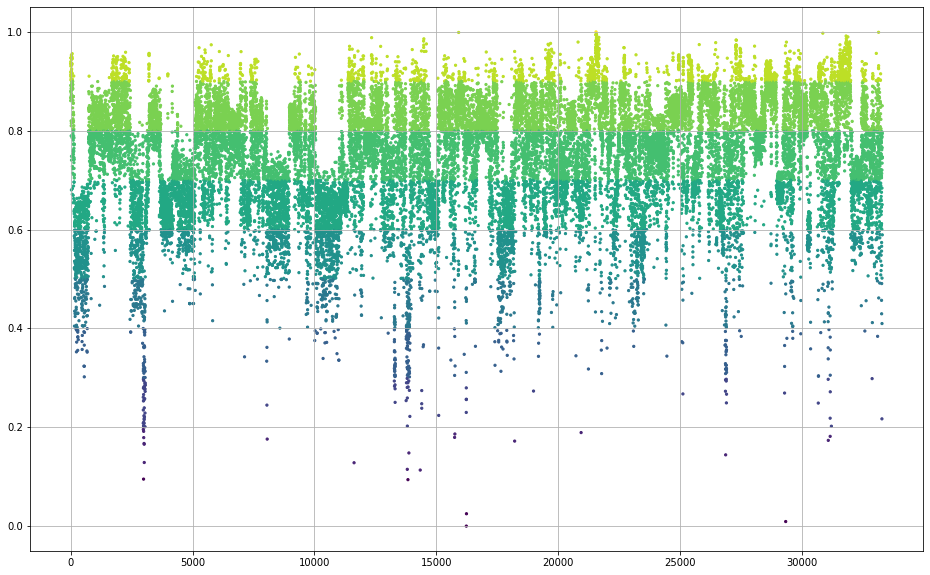

In [11]:
fig, ax = plt.subplots(figsize=(16,10))
im=ax.scatter(x=df.index,y=P,c=np.multiply(P,10).astype(int),s=5)
ax.grid(True)
plt.show()

#### Feature Importance

In [ ]:
warnings.filterwarnings('ignore')
#k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, random_state=1))
k_explainer = shap.KernelExplainer(estimator.predict, shap.sample(X_train, nsamples=500, random_state=1))
X_test_sample=shap.sample(X_test,random_state=1)
k_shap_values = k_explainer.shap_values(X_test_sample) # More Sample Need more time
warnings.filterwarnings('once')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   18.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   18.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Don

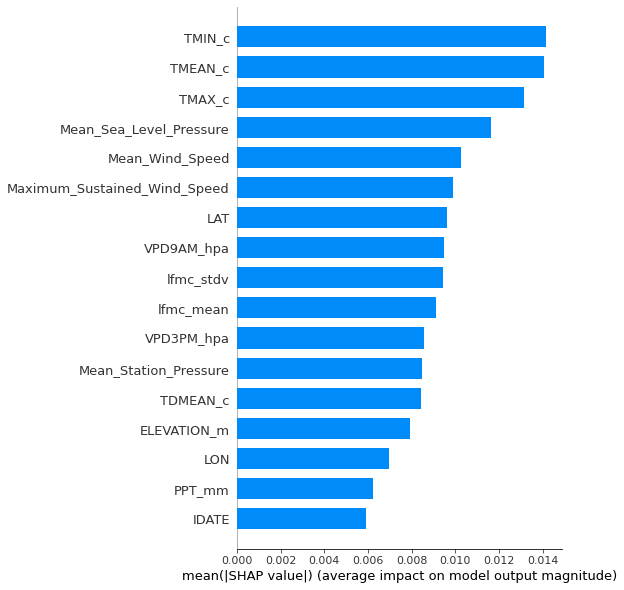

In [ ]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample, plot_type="bar")

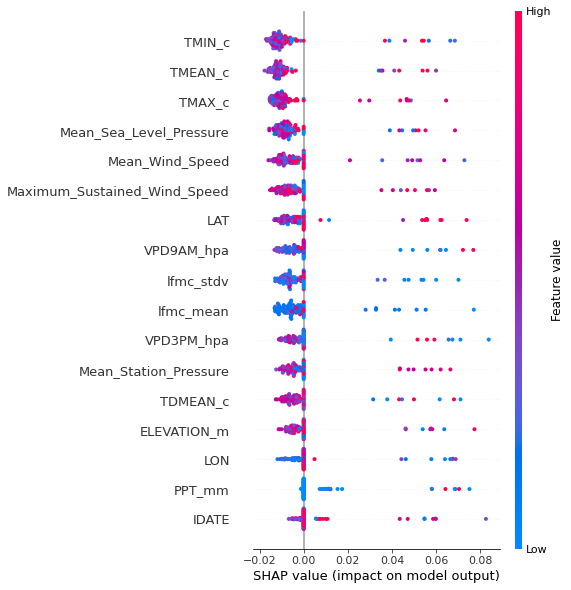

In [ ]:
shap.initjs()
shap.summary_plot(k_shap_values, X_test_sample)

In [ ]:
shap.initjs()
shap.force_plot(k_explainer.expected_value, k_shap_values, X_test_sample)

In [ ]:
feature_names = X_train.columns
rf_resultX = pd.DataFrame(k_shap_values, columns = feature_names)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
#shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
0,IDATE,0.005923
1,LAT,0.009637
2,LON,0.006983
3,ELEVATION_m,0.007917
4,PPT_mm,0.006229
5,TMIN_c,0.014151
6,TMEAN_c,0.014066
7,TMAX_c,0.013150
8,TDMEAN_c,0.008418
9,lfmc_mean,0.009125


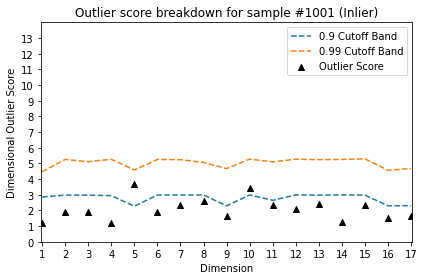

In [ ]:
estimator.explain_outlier(1000)